# <font color="#5fa8d3"> Claim Costs

## <font color="#62b6cb"> Table of Content <a name="ToC"></a>
0. [Libraries Importation & Funtions Definition](#id0)<br>
1. [Syntetic Dataset](#id1)<br>
    1.1 [Repair Cost](#id11)<br>
    1.2 [Labour Cost](#id12)<br>
    1.3 [Total Cost Dataset](#id13)<br>
2. [Cost Model](#id2)<br>

## <font color="#62b6cb"> 0. Libraries Importation & Funtions Definition <a name="id0"></a>

**Libraries Importation**

In [1]:
import json # to import jsons
import pandas as pd # to manipulate datasets
import numpy as np # to perform numerical operations
import matplotlib.pyplot as plt # for plotting
import seaborn as sns # for plotting nicer
from scipy.stats import gamma

**Truncated Gamma Function**

We create the truncated gamma function for modelling the different damage types claims:

In [40]:
def truncated_gamma(shape, scale, lower, upper, size):
    samples = []
    while len(samples) < size:
        sample = gamma(shape, scale=scale).rvs(size)
        sample = sample[(sample >= lower) & (sample <= upper)]
        samples.extend(sample)
    return np.array(samples[:size])

**Damage Type Montecarlo Simulation Function**

In [41]:
def simulate_data(n=5000, damage_type="glass_crack", low_trunc=100, high_trunc=400,
                  brands={"Toyota": 1, "Volkswagen": 1.25},
                  models={"Yaris": 0.75, "Corolla": 1, "C-HR": 1.20, "Polo": 0.73, "Golf": 1, "Tiguan": 1.45},
                  model_brand={"Yaris": "Toyota", "Corolla": "Toyota", "C-HR": "Toyota", "Polo": "Volkswagen", "Golf": "Volkswagen", "Tiguan": "Volkswagen"},
                  age_range={"Newer": 0.8, "Middle": 1, "Old": 0.5},
                  model_effect=1,
                  age_effect=1):

    gamma_shape_base = 1.5
    gamma_scale_base = 100
    
    df_combined = pd.DataFrame()
    
    for brand, brand_multiplier in brands.items():
        for model, model_multiplier in models.items():
            if model_brand[model] != brand:
                continue
            
            # Lower age case
            veh_age_lower = np.random.randint(0, 8, size=n)  # 0 to 7
            cost_lower = truncated_gamma(
                gamma_shape_base, gamma_scale_base * age_range["Newer"] * model_multiplier * brand_multiplier * model_effect,
                low_trunc * model_multiplier * model_effect * brand_multiplier * age_range["Newer"] * age_effect,
                high_trunc * model_multiplier * model_effect * brand_multiplier * age_range["Newer"] * age_effect,
                n)
            
            # Base case
            veh_age_base = np.random.randint(7, 11, size=n)  # 7 to 10
            cost_base = truncated_gamma(
                gamma_shape_base, gamma_scale_base * age_range["Middle"] * model_multiplier * brand_multiplier * model_effect,
                low_trunc * model_multiplier * model_effect * brand_multiplier * age_range["Middle"],
                high_trunc * model_multiplier * model_effect * brand_multiplier * age_range["Middle"],
                n)
            
            # Higher age case
            veh_age_higher = np.random.randint(10, 16, size=n)  # 10 to 15
            cost_higher = truncated_gamma(
                gamma_shape_base, gamma_scale_base * age_range["Old"] * model_multiplier * brand_multiplier * model_effect,
                low_trunc * model_multiplier * model_effect * brand_multiplier * age_range["Old"] * age_effect,
                high_trunc * model_multiplier * model_effect * brand_multiplier * age_range["Old"] * age_effect,
                n)
            
            # Create DataFrames
            df_lower = pd.DataFrame({
                "brand": [brand] * n,
                "model": [model] * n,
                "veh_age": veh_age_lower,
                "veh_age_range": "Newer",
                "damage_type": [damage_type] * n,
                "cost": cost_lower
            })

            df_base = pd.DataFrame({
                "brand": [brand] * n,
                "model": [model] * n,
                "veh_age": veh_age_base,
                "veh_age_range": "Middle",
                "damage_type": [damage_type] * n,
                "cost": cost_base
            })
        
            df_higher = pd.DataFrame({
                "brand": [brand] * n,
                "model": [model] * n,
                "veh_age": veh_age_higher,
                "veh_age_range": "Old",
                "damage_type": [damage_type] * n,
                "cost": cost_higher
            })
            
            # Combine DataFrames for the current model
            df_model_combined = pd.concat([df_lower, df_base, df_higher], ignore_index=True)
            df_combined = pd.concat([df_combined, df_model_combined], ignore_index=True)
    
    # Shuffle the combined DataFrame
    df_combined = df_combined.sample(frac=1).reset_index(drop=True)
    
    return df_combined

**Cost Type Simulation Analysis Function**

In [48]:
def cost_analysis(df_combined, models, 
                  model_brand={"Yaris": "Toyota", "Corolla": "Toyota", "C-HR": "Toyota", "Polo": "Volkswagen", "Golf": "Volkswagen", "Tiguan": "Volkswagen"}, 
                  age=["Newer","Middle","Old"]):
    """Plots density and histograms of cost type by vehicle age range and model."""
    # Set the dark theme
    sns.set_theme(style="dark")
    
    # Define a custom color palette
    palette = {
        "Yaris": "blue",
        "Corolla": "green",
        "C-HR": "red",
        "Polo": "blue",
        "Golf": "green",
        "Tiguan": "red"
    }
    
    # Plot density of cost with histogram by veh_age_range for each model
    ordered_models = sorted(models.items(), key=lambda item: item[1])
    
    for age_type in age:
        fig, axes = plt.subplots(1, 2, figsize=(19, 5), sharey=True)
        
        for i, brand in enumerate(["Toyota", "Volkswagen"]):
            ax = axes[i]
            brand_models = [model for model in models if model_brand[model] == brand]
            
            # Plot the histogram
            sns.histplot(
                df_combined[(df_combined['veh_age_range'] == age_type) & (df_combined['brand'] == brand)],
                x="cost", hue="model", bins=50, edgecolor='black', palette=palette, ax=ax,
                stat="density", common_norm=False
            )
            
            # Add KDE plots with thicker lines
            for model in brand_models:
                sns.kdeplot(
                    df_combined[(df_combined['veh_age_range'] == age_type) & (df_combined['brand'] == brand) & (df_combined['model'] == model)]['cost'],
                    ax=ax, linewidth=3, label=model, color=palette[model]
                )
            
            ax.set_title(f'Density Plot and Histogram of Cost by Vehicle Age Range for {brand} - {age_type}')
            ax.set_xlabel('Cost')
            ax.set_ylabel('Density')
        
        plt.tight_layout()
        plt.show()
    
    # Summary statistics of cost by veh_age_range, model, and brand
    summary_stats = df_combined.groupby(['brand', 'model', 'veh_age_range'])['cost'].describe().drop(columns='count').round(0).astype(int)
    
    # Reorder the index based on the desired order
    summary_stats = summary_stats.reindex([("Toyota", model, age_type) for model in model_brand if model_brand[model] == "Toyota" for age_type in age] +
                                          [("Volkswagen", model, age_type) for model in model_brand if model_brand[model] == "Volkswagen" for age_type in age])
    
    # Print the formatted and ordered summary statistics
    print("Summary statistics by brand, model, and vehicle age range:")
    print(summary_stats)

## <font color="#62b6cb"> 1. Synthetic Dataset <a name="id1"></a>

First we check again the claim classes that exist:

In [2]:
# Load the JSON data from the file
with open('./archive/train.json') as f:
    data = json.load(f)

# Initialize a set to hold unique classes
unique_classes = set()

# Iterate through the items in the JSON data
for item in data.values():
    # Iterate through each region in the item's regions
    for region in item['regions']:
        # Add the class to the set
        unique_classes.add(region['class'])

# Print the unique classes
print("Unique classes:", unique_classes)

Unique classes: {'vo_kinh', 'mat_bo_phan', 'tray_son', 'thung', 'be_den', 'mop_lom', 'rach'}


**Classes explanation**

* mat_bo_phan=lost parts (Miscellaneous Damage)
* rach=torn (Metal damage tear)
* mop_lom=dented (Metal damage dent)
* tray_son=paint scratches (Metal damage scratches)
* thung=puncture (Miscellaneous Damage)
* vo_kinh=broken glass (Glass damage crack)
* be_den= broken lamp (Miscellaneous Damage)

To do this synthetic dataset we will just focus on the top 2 most popular car brands currently in Ireland by this [webpage](https://www.cso.ie/en/releasesandpublications/ep/p-ieu50/irelandandtheeuat50/society/carmakes/): Toyota and Volkswagen.

Besides to simplify it we will take just the main top 3 sales car models (not considering electric cars) of each one assuming that for each one the  repair cost distribution would change based on price of the model. 

For Toyota the [top3](https://www.toyota.ie/company/news/2023/irelands-best-selling-car-brand) models will be (ordered from [cheaper to more expensive](https://www.toyota.ie/)): Yaris (25k), Corolla (34k) and C-HR(41k). Therefore, Yaris a 25% cheaper and C-HR a 20% more expensive than Corolla.

For Volkswagen the [top3](https://www.cartell.ie/2022/06/most-popular-cars-in-ireland-in-2022/) models will be (ordered [from cheaper to more expensive](https://www.volkswagen.ie/en/new-cars.html)): Polo (24k), Golf (33k) and Tiguan (48k).  Therefore, Polo a 27% cheaper and Tiguan a 45% more expensive than Golf.

In general Toyota cars are [cheaper](https://caredge.com/ranks/maintenance) to repair than Volkswagen for car models of the same class as it is estimated that in 10 year maintenance cost it will be 6k vs 8k so a 25% cheaper.

Lastly we will consider the that cars have 3 different car age ranges. As the average age is [9 years](https://www.simi.ie/en/environment/drive-greener/national-vehicle-fleet) we will assume the following ranges: Newer vehicles [0 years to 7 years], middle age vehicles [7 years to 10 years] and old vehicles [more than 10 years].

The repair total costs usually increases over time at an average rate in [doubling](https://www.oponeo.co.uk/blog/how-expensive-are-car-repairs-over-time) every 5 years. However, this is so because even if the repair cost decreases over time, the frequency of the repair increases. As such, as here we are considering just the severity we can assume that they reduce over time. As we haven't found any webpage referring to the severity of the costs due to the vehicle age (new cars have pieces more sophisticated that are not so commonly fabricated and thus, they are more expensive) we will assume that in general they reduce by half in each of the 3 vehicle age ranges.

As such, we will create $2 \times 3 \times 3 \times 7 = 126$ different repair cost model.

### <font color="#62b6cb">1.1. Repair Cost</font> <a name="id11"></a>

**Glass damage crack (vo_kinh)**

For defining the repairs costs distribution of this damage type, we have looked into the following webpages:
* [airtasker](https://www.airtasker.com/ie/costs/windscreen-repair-replacement/cost-of-windscreen-repairs-and-replacement/)

It states that in general prices go from €100 to €380 with a median of €200.

In [45]:
brands = {"Toyota": 1,"Volkswagen":1.25}

models = {"Yaris": 0.75, 
          "Corolla": 1, 
          "C-HR": 1.20,
          "Polo":0.73,
          "Golf":1,
          "Tiguan":1.45}

age_range={"Newer":0.8,"Middle":1,"Old":0.5}

df_combined_glass_crack = simulate_data(n=5000, damage_type="glass_crack",low_trunc=100,high_trunc=400,
                            brands=brands, models=models,
                            age_range={"Newer":0.8,"Middle":1,"Old":0.5},
                            model_effect=1.4,age_effect=0.7)

In [46]:
df_combined_glass_crack.shape

(90000, 6)

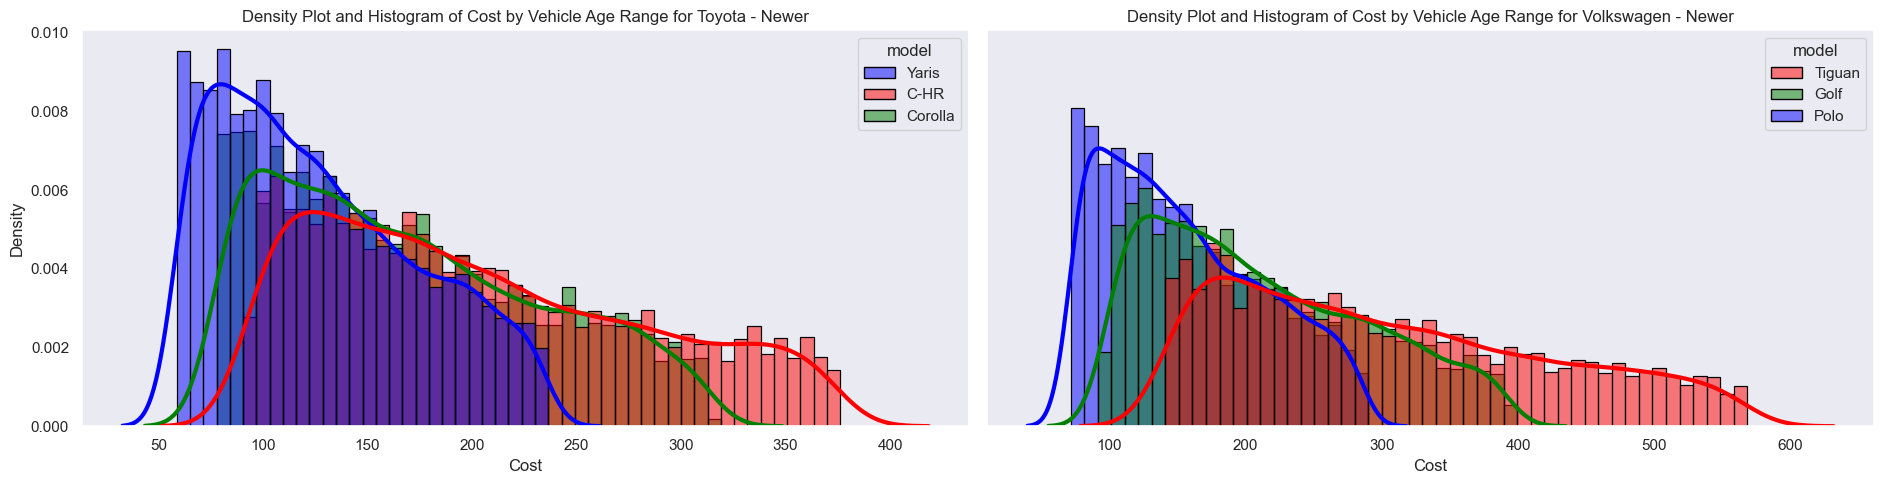

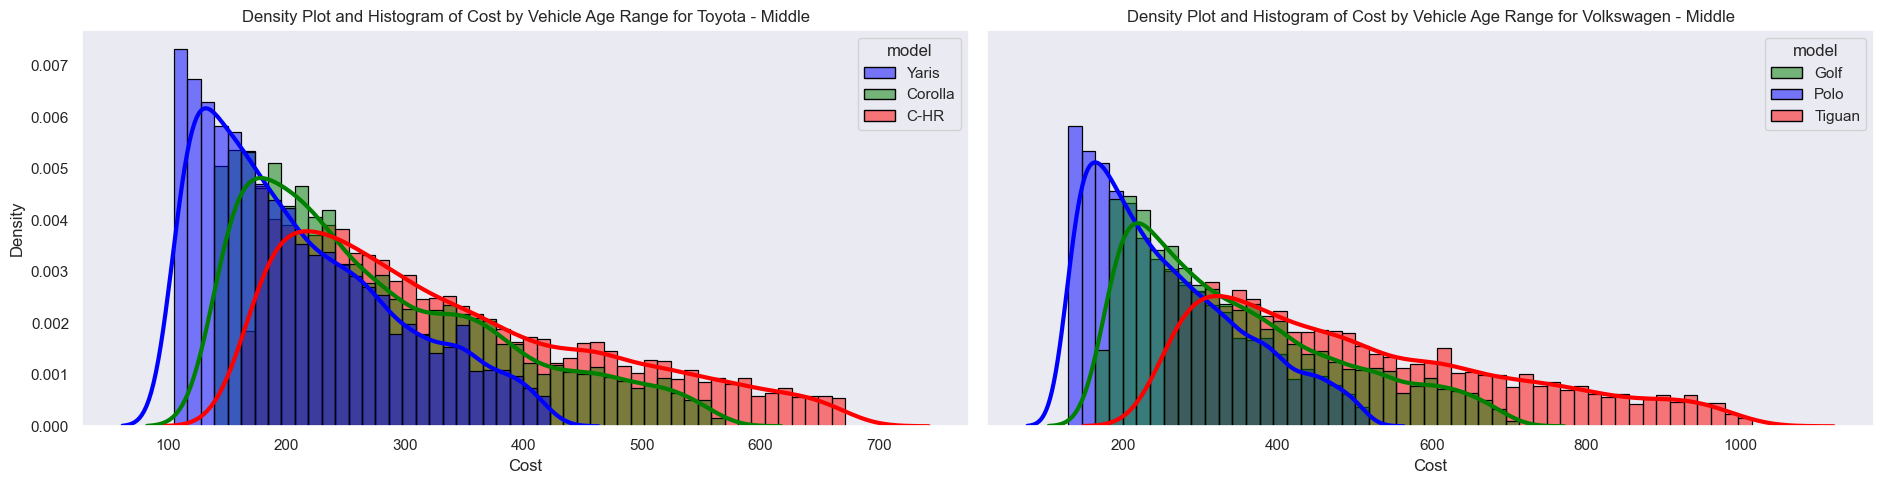

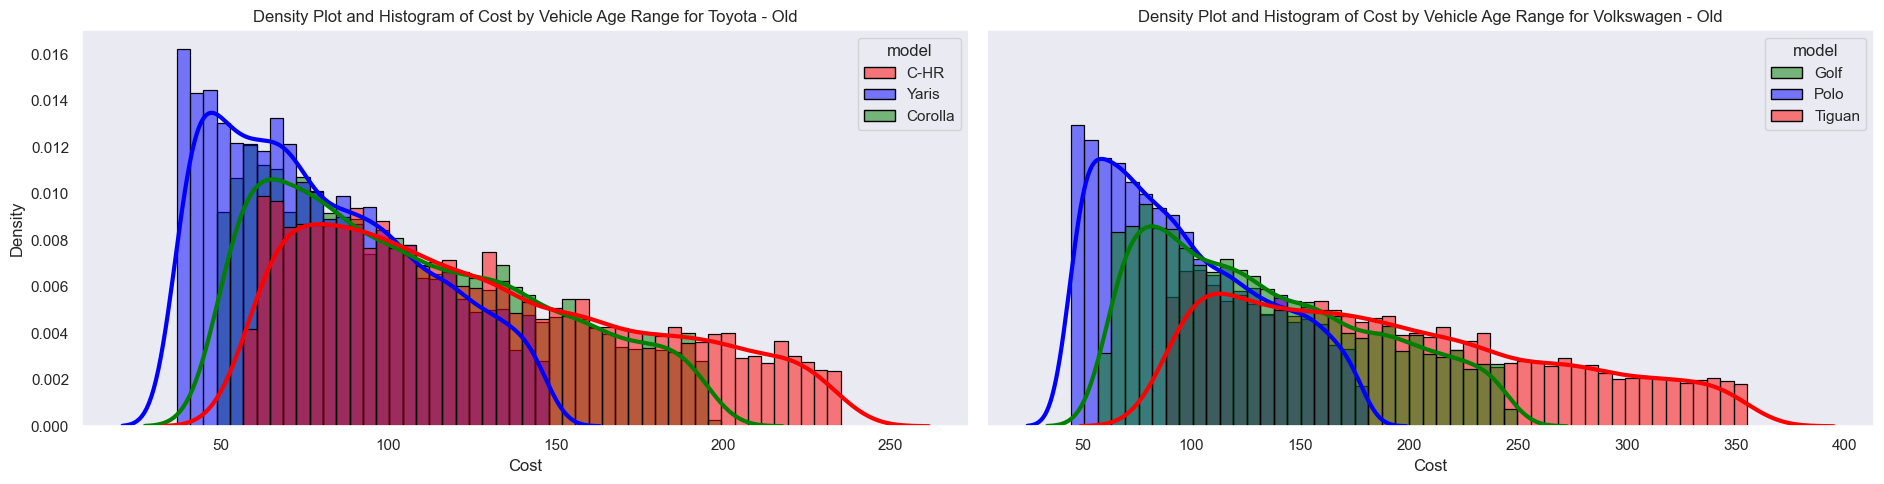

Summary statistics by brand, model, and vehicle age range:
                                  mean  std  min  25%  50%  75%   max
brand      model   veh_age_range                                     
Toyota     Yaris   Newer           127   47   59   87  119  162   235
                   Middle          209   80  105  142  190  261   420
                   Old              80   30   37   54   75  102   147
           Corolla Newer           169   64   78  114  158  217   314
                   Middle          274  106  140  188  246  344   560
                   Old             106   40   49   72  100  136   196
           C-HR    Newer           204   78   94  137  189  262   376
                   Middle          336  129  168  230  304  422   672
                   Old             127   48   59   86  118  163   235
Volkswagen Polo    Newer           155   58   72  105  144  199   286
                   Middle          254   97  128  174  232  318   510
                   Old         

In [49]:
cost_analysis(df_combined_glass_crack, models)

### <font color="#62b6cb">1.2. Labour Cost</font> <a name="id12"></a>

### <font color="#62b6cb">1.3. Total Cost </font> <a name="id13"></a>

## <font color="#62b6cb"> 2. Cost Model <a name="id2"></a>